In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from skimage.exposure import rescale_intensity
import argparse
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata.utils import Cutout2D
from matplotlib.colors import LogNorm, PowerNorm

plt.rcParams["figure.figsize"] = (8,8)

# https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381

In [2]:
def convolve_2D(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Apply a convolution kernel to an image and return the resulting image

    Args:
        image (np.ndarray): M x N image to convolute with kernel
        kernel (np.ndarray): d x d' kernel matrix to apply to image

    Returns:
        np.ndarray: Image convoluted with input kernel
    """
    # "Cross-Correlation"?
    kernel = np.fliplr(np.flipud(kernel))

    # Gather Shapes of Kernel & Image
    kernel_length = kernel.shape[0]
    kernel_width = kernel.shape[1]
    image_length = image.shape[0]
    image_width = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((image_length - kernel_length) + 1)
    yOutput = int((image_width - kernel_width) + 1)
    output = np.zeros((xOutput, yOutput))


    for y in range(image.shape[1]):
        if y > image.shape[1] - kernel_width:
            break
        for x in range(image.shape[0]):
            # Go to next row once kernel is out of bounds
            if x > image.shape[0] - kernel_length:
                break
            output[x, y] = (kernel * image[x: x + kernel_length, y: y + kernel_width]).sum()

    return output;


def gaussian_kernel(size=5, sig=1) -> np.ndarray:
    """Create a square Gaussian kernel function

    Args:
        size (int, optional): matrix size. Defaults to 5.
        sig (int, optional): standard deviation of gaussian. Defaults to 1.

    Returns:
        np.ndarray: size x size normalized gaussian matrix.
    """
    ax = np.linspace(-(size-1)/2, (size-1)/2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)


def get_output(image: np.ndarray, kernel: np.ndarray, floor=1e-10, ceiling=.8) -> np.ndarray:
    """Takes input image and kernel, re-scales image based on floor and ceiling values, then
       returns the image convoluted with the kernel

    Args:
        image (np.ndarray): Image to apply kernel to
        kernel (np.ndarray): Convolution kernel
        floor (_type_, optional): Lower quantile to re-scale pixel values to. Defaults to 1e-10.
        ceiling (float, optional): Upper quantile to re-scale pixel values to. Defaults to .8.

    Returns:
        np.ndarray: New image.
    """

    # Get min and max pixel values
    test_x, test_y = np.where(image > 0)
    values = image[test_x, test_y]
    min_pixel_value = np.quantile(values, floor)
    max_pixel_value = np.quantile(values, ceiling)

    # Level out pixel flux floor and ceiling
    image[np.where(image < min_pixel_value)] = min_pixel_value
    image[np.where(image > max_pixel_value)] = max_pixel_value

    output = convolve_2D(image, kernel)

    return output
    

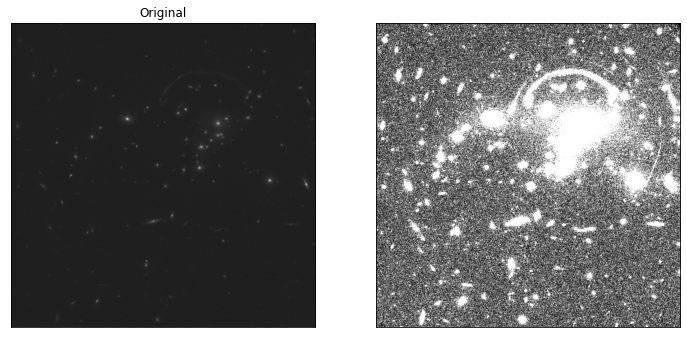

Min Pixel Value: 0.1932682437281139
Max Pixel Value: 0.37976720929145813


In [3]:
"""File Name of Image we want to look at"""
FILE_NAME = "lens"
FLOOR = 1e-10
CEILING = .8

image_file = get_pkg_data_filename('images/{}.fits'.format(FILE_NAME))
image_data = fits.getdata(image_file, ext=1)
length, width = image_data.shape
# position = (length/2 + 100, width/2+90)
position = (length/2, width/2)

"""Size of cutout from center of image"""
# SIZE = int((length + width)/4)
SIZE = 1000

image = Cutout2D(image_data, position=position, size=SIZE).data

fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].imshow(image, cmap="gray", norm=PowerNorm(.5))
axs[0].set_title("Original")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].invert_yaxis()

test_x, test_y = np.where(image > 0)
values = image[test_x, test_y]
min_pixel_value = np.quantile(values, FLOOR)
max_pixel_value = np.quantile(values, CEILING)

# # Set all pixels below min to 1e-10 for log scaling purposes
image[np.where(image < min_pixel_value)] = min_pixel_value
image[np.where(image > max_pixel_value)] = max_pixel_value

axs[1].imshow(image, cmap="gray", norm=PowerNorm(5))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].invert_yaxis()

plt.show()

print("Min Pixel Value: {}\nMax Pixel Value: {}".format(min_pixel_value, max_pixel_value))


In [7]:
# kernel_size = 10
# kernel = np.ones((kernel_size, kernel_size), dtype="float") / (kernel_size**2)
# kernel = [[0,1,1,1,0],[1,1,3,1,1],[1,3,5,3,1],[1,1,3,1,1],[0,1,1,1,0]]
# # kernel = np.array([[1, 1], [-1, -1]])
# # kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
# kernel = np.identity(5)

kernel = gaussian_kernel(size=10, sig=10)
output = get_output(image, kernel)


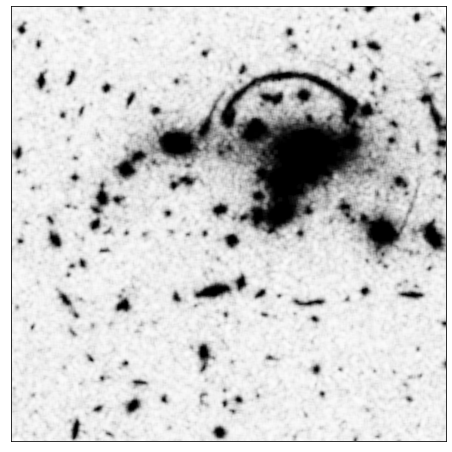

In [5]:
plt.imshow(output, cmap="gray_r", norm=PowerNorm(gamma=10))
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

plt.show()

In [6]:
A = np.array(
    [[1,1,0,1,0,1],
     [0,1,1,0,1,0],
     [1,0,1,1,0,1],
     [0,1,0,1,1,0],
     [1,0,1,1,0,1],
     [1,0,1,1,0,1]])

mask = np.array(
        [[1,2,1],
        [2,4,2],
        [1,2,1]])

convolution = convolve_2D(A, mask)
print(convolution)

[[11. 11.  9.  8.]
 [ 9. 11. 11.  9.]
 [ 8. 10. 12. 10.]
 [ 8. 11. 12.  9.]]
